# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [2]:
%env CUDA_LAUNCH_BLOCKING=1
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

env: CUDA_LAUNCH_BLOCKING=1


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_579363/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_579363/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_579363/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-26 17:13:40,270] A new study created in RDB with name: no-name-4378af9e-37f9-4995-b561-b4b22c919a81
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:618: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<24:19,  1.37it/s]

current_loss: tensor(1.4548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4355581998825073


  0%|          | 2/2000 [00:00<13:51,  2.40it/s]

current_loss: tensor(1.4507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4216850996017456
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<07:57,  4.18it/s]

current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4044580459594727
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3994951248168945


  0%|          | 5/2000 [00:01<07:15,  4.58it/s]

current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3989379405975342


  0%|          | 6/2000 [00:01<06:56,  4.79it/s]

current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3987388610839844
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:15,  4.02it/s]

current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3987129926681519
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:32,  3.48it/s]

current_loss_val:  1.3987383842468262
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<11:20,  2.93it/s]

current_loss_val:  1.3990293741226196
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<11:05,  2.99it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.399065613746643
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:20,  3.55it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3991575241088867
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<10:29,  3.16it/s]


current_loss_val:  1.3992244005203247
Early Stop at iteration 11 with minimal loss tensor(1.3987, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3785, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<13:49,  2.41it/s]

current_loss_val:  1.3570057153701782
current_loss: tensor(1.3785, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<13:22,  2.49it/s]

current_loss: tensor(1.3129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2888695001602173
current_loss: tensor(1.3129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<17:08,  1.94it/s]

current_loss_val:  1.2835310697555542
current_loss: tensor(1.2972, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<15:45,  2.11it/s]

current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2805198431015015
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<14:47,  2.25it/s]

current_loss_val:  1.2770841121673584
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<14:09,  2.35it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745637893676758
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:03<14:02,  2.37it/s]

current_loss_val:  1.2728763818740845
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<16:05,  2.06it/s]

current_loss_val:  1.2725332975387573
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:04<16:03,  2.07it/s]

current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701599597930908
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:04<15:31,  2.14it/s]

current_loss_val:  1.2650269269943237
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:05<16:53,  1.96it/s]

current_loss_val:  1.262353539466858
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:06<14:54,  2.22it/s]

current_loss_val:  1.2591577768325806
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256129503250122


  1%|          | 14/2000 [00:06<11:38,  2.84it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255515456199646
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:06<07:47,  4.25it/s]

current_loss_val:  1.2557350397109985
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559492588043213
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:06<05:52,  5.62it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565268278121948
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2557092905044556
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<04:58,  6.63it/s]

current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548635005950928
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546582221984863


  1%|          | 21/2000 [00:07<04:43,  6.99it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542445659637451
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:07<04:23,  7.52it/s]

current_loss_val:  1.2542273998260498
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539539337158203
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<04:13,  7.81it/s]

current_loss_val:  1.2538237571716309
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532658576965332
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<04:08,  7.93it/s]

current_loss_val:  1.252286434173584
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509759664535522
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<04:08,  7.92it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505394220352173
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504624128341675


  2%|▏         | 30/2000 [00:08<04:07,  7.96it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250132441520691
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:08<04:05,  8.02it/s]

current_loss_val:  1.2496769428253174
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478810548782349
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<04:04,  8.04it/s]

current_loss_val:  1.2471206188201904
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459436655044556
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:08<04:03,  8.07it/s]

current_loss_val:  1.24527108669281
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451714277267456
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:09<04:01,  8.11it/s]

current_loss_val:  1.2452659606933594
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450132369995117
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:09<04:01,  8.11it/s]

current_loss_val:  1.2440423965454102
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435423135757446
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:09<04:00,  8.13it/s]

current_loss_val:  1.2431882619857788
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439709901809692
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:09<04:03,  8.04it/s]

current_loss_val:  1.243804693222046
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243733525276184
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:10<07:22,  4.42it/s]

current_loss_val:  1.2438535690307617
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436450719833374
Early Stop at iteration 45 with minimal loss tensor(1.2432, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:01,233] Trial 0 finished with value: -2.4863762855529785 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1470215092836464, 'penalty_decorrelation_ridge_second_difference': 15.156431519502537}. Best is trial 0 with value: -2.4863762855529785.
  0%|          | 1/2000 [00:00<05:37,  5.93it/s]

current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243615746498108
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436755895614624
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439453601837158


  0%|          | 4/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243808627128601
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:13,  7.87it/s]

current_loss_val:  1.2433561086654663
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432547807693481
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:09,  7.98it/s]

current_loss_val:  1.242822527885437
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242773413658142
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:29,  7.39it/s]

current_loss_val:  1.2430343627929688
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432979345321655
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:18,  7.69it/s]

current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432388067245483
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433735132217407


  1%|          | 12/2000 [00:01<04:42,  7.05it/s]


current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433596849441528
Early Stop at iteration 12 with minimal loss tensor(1.2428, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:04,050] Trial 1 finished with value: -2.485546827316284 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7380469536711807, 'penalty_decorrelation_ridge_second_difference': 16.499422084491233}. Best is trial 1 with value: -2.485546827316284.
  0%|          | 1/2000 [00:00<05:44,  5.80it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439556121826172
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:27,  7.45it/s]

current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439697980880737
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244147777557373


  0%|          | 4/2000 [00:00<04:23,  7.57it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438372373580933
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:35,  7.24it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430224418640137
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431169748306274


  0%|          | 7/2000 [00:00<04:26,  7.49it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437242269515991
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:34,  7.25it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446638345718384
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445969581604004


  0%|          | 9/2000 [00:01<05:06,  6.50it/s]


current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445460557937622
Early Stop at iteration 9 with minimal loss tensor(1.2430, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:06,552] Trial 2 finished with value: -2.4860446453094482 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.645530203885562, 'penalty_decorrelation_ridge_second_difference': 8.339675272597027}. Best is trial 1 with value: -2.485546827316284.
  0%|          | 1/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244181513786316
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440578937530518
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244019865989685


  0%|          | 4/2000 [00:00<04:21,  7.64it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446157932281494
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:15,  7.81it/s]

current_loss_val:  1.2444937229156494
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244114875793457
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:12,  7.88it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243953824043274
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:31,  7.35it/s]

current_loss_val:  1.2442127466201782
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443640232086182
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:18,  7.71it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445884943008423
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449573278427124


  1%|          | 11/2000 [00:01<04:47,  6.93it/s]


current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453608512878418
Early Stop at iteration 11 with minimal loss tensor(1.2440, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:09,425] Trial 3 finished with value: -2.4879074096679688 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.960571131445358, 'penalty_decorrelation_ridge_second_difference': 29.572072222636606}. Best is trial 1 with value: -2.485546827316284.
  0%|          | 1/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442059516906738
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441462278366089
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244348168373108


  0%|          | 4/2000 [00:00<04:20,  7.67it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441924810409546
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:13,  7.87it/s]

current_loss_val:  1.2441569566726685
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243997573852539
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:01<04:09,  7.97it/s]

tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439696788787842
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436774969100952


  0%|          | 9/2000 [00:01<04:09,  7.99it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441141605377197
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:10,  7.94it/s]

current_loss_val:  1.2435708045959473
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434759140014648
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:07,  8.03it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243411898612976
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434395551681519


  1%|          | 14/2000 [00:01<04:07,  8.01it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243489384651184
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:07,  8.03it/s]

current_loss_val:  1.2440067529678345
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244547724723816
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:37,  7.14it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449305057525635
Early Stop at iteration 16 with minimal loss tensor(1.2434, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:12,762] Trial 4 finished with value: -2.486823797225952 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.567423864738958, 'penalty_decorrelation_ridge_second_difference': 13.32280181010191}. Best is trial 1 with value: -2.485546827316284.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:55,  3.36it/s]

current_loss_val:  1.248323917388916
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244689702987671
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:03,  5.50it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434056997299194
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243091106414795
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243552803993225


  0%|          | 6/2000 [00:01<10:32,  3.15it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245819091796875
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:57,  3.71it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464754581451416
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:06,  3.65it/s]

current_loss_val:  1.2466099262237549
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467058897018433
Early Stop at iteration 8 with minimal loss tensor(1.2431, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:16,090] Trial 5 finished with value: -2.4861819744110107 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.0914672084965, 'penalty_decorrelation_ridge_second_difference': 27.0367999384908}. Best is trial 1 with value: -2.485546827316284.
  0%|          | 1/2000 [00:00<04:09,  8.01it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24822199344635
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:10,  7.99it/s]

current_loss_val:  1.2447359561920166
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243422031402588
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:12,  7.89it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431209087371826
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425777912139893


  0%|          | 6/2000 [00:00<04:41,  7.09it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444119453430176
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:23,  7.56it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244486689567566
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456594705581665


  0%|          | 9/2000 [00:01<04:19,  7.67it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463511228561401
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:47,  6.92it/s]


current_loss_val:  1.246602177619934
Early Stop at iteration 9 with minimal loss tensor(1.2426, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:18,723] Trial 6 finished with value: -2.4851555824279785 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.516849876677774, 'penalty_decorrelation_ridge_second_difference': 13.269931080822243}. Best is trial 6 with value: -2.4851555824279785.
  0%|          | 1/2000 [00:00<04:24,  7.56it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482972145080566
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:14,  7.83it/s]

current_loss_val:  1.2452114820480347
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442227602005005
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:13,  7.87it/s]

current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451140880584717
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:32,  7.32it/s]

current_loss_val:  1.246408224105835
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245887041091919
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:24,  7.53it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461273670196533
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:13,  6.36it/s]


current_loss_val:  1.2466545104980469
Early Stop at iteration 7 with minimal loss tensor(1.2442, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:21,114] Trial 7 finished with value: -2.488445281982422 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.40404685729614, 'penalty_decorrelation_ridge_second_difference': 21.3737896134406}. Best is trial 6 with value: -2.4851555824279785.
  0%|          | 1/2000 [00:00<04:12,  7.91it/s]

current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482835054397583
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:17,  7.75it/s]

current_loss_val:  1.244943618774414
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435859441757202
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:13,  7.86it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435781955718994
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539812326431274


  0%|          | 6/2000 [00:00<04:11,  7.92it/s]

current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468105554580688
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:15,  7.81it/s]

current_loss_val:  1.246482014656067
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245643138885498
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:45,  6.97it/s]


current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448017597198486
Early Stop at iteration 8 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:23,590] Trial 8 finished with value: -2.4871561527252197 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.905861681886083, 'penalty_decorrelation_ridge_second_difference': 21.111042641166826}. Best is trial 6 with value: -2.4851555824279785.
  0%|          | 1/2000 [00:00<05:40,  5.86it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439640760421753
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243910789489746
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439241409301758


  0%|          | 4/2000 [00:00<04:21,  7.62it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440000772476196
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:16,  7.77it/s]

current_loss_val:  1.243743896484375
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434715032577515
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:11,  7.92it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436856031417847
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436068058013916


  0%|          | 9/2000 [00:01<04:11,  7.92it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436329126358032
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:43,  7.02it/s]

current_loss_val:  1.2436918020248413
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243808627128601
Early Stop at iteration 10 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:26,194] Trial 9 finished with value: -2.486942768096924 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.116217697304013, 'penalty_decorrelation_ridge_second_difference': 26.27648943693197}. Best is trial 6 with value: -2.4851555824279785.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243606448173523
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:38,  5.90it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444432973861694
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:15,  6.32it/s]

current_loss_val:  1.244025468826294
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243323564529419


  0%|          | 5/2000 [00:00<04:52,  6.83it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416987419128418
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:29,  7.40it/s]

current_loss_val:  1.241868495941162
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429529428482056
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:24,  7.53it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431457042694092
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:19,  6.23it/s]

current_loss_val:  1.2429280281066895
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243167519569397
Early Stop at iteration 9 with minimal loss tensor(1.2417, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:28,961] Trial 10 finished with value: -2.4833972454071045 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.482326293956213, 'penalty_decorrelation_ridge_second_difference': 1.292213959666525}. Best is trial 10 with value: -2.4833972454071045.
  0%|          | 1/2000 [00:00<04:05,  8.14it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482614517211914
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:09,  8.00it/s]

current_loss_val:  1.2448399066925049
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434488534927368
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:10,  7.97it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243235468864441
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456213235855103


  0%|          | 6/2000 [00:00<04:17,  7.75it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474114894866943
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:14,  7.84it/s]

current_loss_val:  1.2463077306747437
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461062669754028
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:43,  7.01it/s]


current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245097041130066
Early Stop at iteration 8 with minimal loss tensor(1.2432, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:31,338] Trial 11 finished with value: -2.4864706993103027 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.813467959979878, 'penalty_decorrelation_ridge_second_difference': 18.685716814882163}. Best is trial 10 with value: -2.4833972454071045.
  0%|          | 1/2000 [00:00<04:09,  8.02it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481353282928467
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:11,  7.95it/s]

current_loss_val:  1.2448043823242188
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434043884277344
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:11,  7.93it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431246042251587
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242713451385498


  0%|          | 6/2000 [00:00<04:40,  7.10it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442266941070557
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:23,  7.55it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443490028381348
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462553977966309


  0%|          | 9/2000 [00:01<04:47,  6.91it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24550461769104
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:57,  6.69it/s]


current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245282530784607
Early Stop at iteration 9 with minimal loss tensor(1.2427, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:34,100] Trial 12 finished with value: -2.485426664352417 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.53343860186574, 'penalty_decorrelation_ridge_second_difference': 0.3971056891186173}. Best is trial 10 with value: -2.4833972454071045.
  0%|          | 1/2000 [00:00<05:43,  5.83it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243648648262024
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442353963851929
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:19,  6.26it/s]

current_loss_val:  1.244016170501709
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431328296661377


  0%|          | 5/2000 [00:00<07:39,  4.34it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416104078292847
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:43,  5.80it/s]

current_loss_val:  1.2419402599334717
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423286437988281
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:14,  6.33it/s]

current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425386905670166
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:11,  5.36it/s]

current_loss_val:  1.2430843114852905
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430610656738281
Early Stop at iteration 9 with minimal loss tensor(1.2416, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:37,009] Trial 13 finished with value: -2.4832208156585693 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.58763172027729, 'penalty_decorrelation_ridge_second_difference': 2.126278598424696}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446379661560059
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443557977676392
current_loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444559335708618


  0%|          | 4/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2458823919296265
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:17,  7.76it/s]

current_loss_val:  1.245713710784912
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245206594467163
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<05:08,  6.47it/s]


current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446751594543457
Early Stop at iteration 6 with minimal loss tensor(1.2444, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:39,153] Trial 14 finished with value: -2.488711357116699 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.124599696366232, 'penalty_decorrelation_ridge_second_difference': 29.324243241732347}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:45,  5.78it/s]

current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435352802276611
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436046600341797
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440555095672607


  0%|          | 4/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442644834518433
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:42,  5.83it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243894338607788
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438421249389648
Early Stop at iteration 5 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:41,476] Trial 15 finished with value: -2.487070322036743 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.136646965621849, 'penalty_decorrelation_ridge_second_difference': 2.512544528150075}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437212467193604
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:40,  5.87it/s]

current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244822382926941
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:17,  6.29it/s]

current_loss_val:  1.2440545558929443
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432934045791626


  0%|          | 5/2000 [00:00<04:53,  6.80it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417280673980713
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:30,  7.37it/s]

current_loss_val:  1.2419930696487427
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425596714019775
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:18,  7.71it/s]

current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242746353149414
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430955171585083


  0%|          | 9/2000 [00:01<05:08,  6.45it/s]


current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243369698524475
Early Stop at iteration 9 with minimal loss tensor(1.2417, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:44,193] Trial 16 finished with value: -2.4834563732147217 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.587959346849587, 'penalty_decorrelation_ridge_second_difference': 1.274486506725681}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:42,  5.84it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243678331375122
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437275648117065
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439543008804321


  0%|          | 4/2000 [00:00<04:24,  7.54it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243472933769226
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:38,  7.17it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425081729888916
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24241304397583


  0%|          | 7/2000 [00:00<04:29,  7.40it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423510551452637
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:39,  7.11it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429853677749634
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430992126464844


  0%|          | 10/2000 [00:01<04:30,  7.36it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435325384140015
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:58,  6.66it/s]

current_loss_val:  1.2438373565673828
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433264255523682
Early Stop at iteration 11 with minimal loss tensor(1.2424, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:47,001] Trial 17 finished with value: -2.484701633453369 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.713696599777434, 'penalty_decorrelation_ridge_second_difference': 7.569872159197427}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244072437286377
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244083046913147
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442249059677124


  0%|          | 4/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446495294570923
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:39,  7.13it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24351167678833
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435919046401978


  0%|          | 7/2000 [00:00<04:29,  7.38it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449780702590942
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:53,  6.78it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444831132888794
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:19,  6.23it/s]

current_loss_val:  1.2436562776565552
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244065761566162
Early Stop at iteration 9 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:49,786] Trial 18 finished with value: -2.487023115158081 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.27928586460302, 'penalty_decorrelation_ridge_second_difference': 3.482631937497266}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:40,  5.88it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435721158981323
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436293363571167
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243983268737793


  0%|          | 4/2000 [00:00<04:23,  7.59it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437323331832886
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:38,  7.17it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427836656570435
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425180673599243


  0%|          | 7/2000 [00:00<04:30,  7.38it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421114444732666
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:49,  6.89it/s]

current_loss_val:  1.2428873777389526
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428025007247925


  0%|          | 10/2000 [00:01<04:36,  7.19it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428804636001587
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:07,  6.47it/s]

current_loss_val:  1.2428491115570068
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243093490600586
Early Stop at iteration 11 with minimal loss tensor(1.2421, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:53,272] Trial 19 finished with value: -2.484222650527954 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.871196710273284, 'penalty_decorrelation_ridge_second_difference': 1.8031090715131177}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:45,  5.79it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438968420028687
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438945770263672
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440547943115234


  0%|          | 4/2000 [00:00<04:25,  7.51it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436538934707642
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:40,  7.12it/s]

current_loss_val:  1.2429453134536743
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243272304534912
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:31,  7.35it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24320650100708
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432351112365723


  0%|          | 9/2000 [00:01<04:25,  7.51it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243707537651062
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:00,  6.63it/s]


current_loss_val:  1.2436152696609497
Early Stop at iteration 9 with minimal loss tensor(1.2429, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:14:55,922] Trial 20 finished with value: -2.4858906269073486 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.758712120401281, 'penalty_decorrelation_ridge_second_difference': 16.07648397619459}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437034845352173
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:40,  5.86it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447729110717773
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:20,  6.22it/s]

current_loss_val:  1.2440664768218994
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432891130447388


  0%|          | 5/2000 [00:00<04:56,  6.73it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417027950286865
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:32,  7.30it/s]

current_loss_val:  1.241946816444397
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427245378494263
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:54,  6.77it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242908239364624
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:31,  6.01it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426553964614868
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431423664093018
Early Stop at iteration 9 with minimal loss tensor(1.2417, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:14:58,846] Trial 21 finished with value: -2.483405590057373 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.324302303957916, 'penalty_decorrelation_ridge_second_difference': 0.7845015950984668}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438793182373047
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:55,  5.61it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443594932556152
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:36,  5.94it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441370487213135
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:13,  6.36it/s]

current_loss_val:  1.243552565574646
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242319107055664
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:39,  7.13it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424781322479248
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242850422859192


  0%|          | 8/2000 [00:01<04:31,  7.35it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430185079574585
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:22,  6.18it/s]

current_loss_val:  1.2440860271453857
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435106039047241
Early Stop at iteration 9 with minimal loss tensor(1.2423, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:15:01,777] Trial 22 finished with value: -2.484638214111328 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.621431640015818, 'penalty_decorrelation_ridge_second_difference': 0.12470598588782078}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:48,  5.74it/s]

current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436199188232422
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:38,  7.17it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436753511428833
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439301013946533


  0%|          | 4/2000 [00:00<04:31,  7.36it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435928583145142
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:45,  6.99it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426480054855347
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242441177368164


  0%|          | 7/2000 [00:00<04:35,  7.24it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421296834945679
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:26,  7.47it/s]

current_loss_val:  1.2443745136260986
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434223890304565
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:18,  7.69it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433767318725586
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432633638381958


  1%|          | 11/2000 [00:01<04:55,  6.73it/s]


current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427847385406494
Early Stop at iteration 11 with minimal loss tensor(1.2421, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:15:05,020] Trial 23 finished with value: -2.4842593669891357 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.548645840526934, 'penalty_decorrelation_ridge_second_difference': 8.370535810705071}. Best is trial 13 with value: -2.4832208156585693.
  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435986995697021
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:41,  5.86it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244288444519043
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:21,  6.21it/s]

current_loss_val:  1.2440613508224487
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431174516677856


  0%|          | 5/2000 [00:00<05:00,  6.63it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415153980255127
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:35,  7.25it/s]

current_loss_val:  1.241803765296936
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425739765167236
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:22,  7.58it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242944598197937
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242777705192566


  0%|          | 9/2000 [00:01<05:12,  6.37it/s]


current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425168752670288
Early Stop at iteration 9 with minimal loss tensor(1.2415, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:15:07,480] Trial 24 finished with value: -2.4830307960510254 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.533750483766962, 'penalty_decorrelation_ridge_second_difference': 0.020514291944124796}. Best is trial 24 with value: -2.4830307960510254.
  0%|          | 1/2000 [00:00<06:10,  5.40it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243533968925476
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:41,  7.09it/s]

current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435966730117798
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440162897109985


  0%|          | 4/2000 [00:00<04:33,  7.30it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441476583480835
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:43,  7.03it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243448257446289
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431789636611938


  0%|          | 7/2000 [00:00<04:33,  7.28it/s]

current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242925763130188
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:53,  6.79it/s]

current_loss_val:  1.2428022623062134
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425322532653809


  0%|          | 10/2000 [00:01<04:41,  7.07it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427433729171753
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:27,  7.42it/s]

current_loss_val:  1.2430462837219238
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243076205253601
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<04:49,  6.86it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426764965057373
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:03,  6.54it/s]


current_loss_val:  1.2430698871612549
Early Stop at iteration 13 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:15:10,176] Trial 25 finished with value: -2.4850645065307617 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.314301230710625, 'penalty_decorrelation_ridge_second_difference': 0.06183956082069941}. Best is trial 24 with value: -2.4830307960510254.
  0%|          | 1/2000 [00:00<05:51,  5.68it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435579299926758
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:42,  7.06it/s]

current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436225414276123
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439336776733398


  0%|          | 4/2000 [00:00<04:31,  7.35it/s]

current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438756227493286
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:44,  7.00it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243233561515808
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243021011352539


  0%|          | 7/2000 [00:00<04:34,  7.25it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242672085762024
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:52,  6.80it/s]

current_loss_val:  1.2425445318222046
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429039478302002


  0%|          | 10/2000 [00:01<05:08,  6.46it/s]

current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242749810218811
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:20,  6.21it/s]

current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432677745819092
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<05:15,  6.30it/s]

current_loss_val:  1.2433286905288696
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243528127670288
Early Stop at iteration 12 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:15:12,770] Trial 26 finished with value: -2.48508882522583 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.454245833838133, 'penalty_decorrelation_ridge_second_difference': 7.190192365971958}. Best is trial 24 with value: -2.4830307960510254.
  0%|          | 1/2000 [00:00<04:46,  6.97it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481858730316162
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:26,  7.48it/s]

current_loss_val:  1.244655966758728
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434695959091187
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:19,  7.70it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431484460830688
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242435097694397


  0%|          | 6/2000 [00:00<04:47,  6.94it/s]

current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445526123046875
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:30,  7.37it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445411682128906
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452024221420288


  0%|          | 9/2000 [00:01<04:22,  7.59it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467962503433228
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:57,  6.70it/s]


current_loss_val:  1.2468221187591553
Early Stop at iteration 9 with minimal loss tensor(1.2424, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:15:14,836] Trial 27 finished with value: -2.484870433807373 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.594711614008347, 'penalty_decorrelation_ridge_second_difference': 7.787712007786565}. Best is trial 24 with value: -2.4830307960510254.
  0%|          | 1/2000 [00:00<06:32,  5.09it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438724040985107


  0%|          | 2/2000 [00:00<05:41,  5.85it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439011335372925
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:27,  6.09it/s]

current_loss_val:  1.2440688610076904
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437318563461304


  0%|          | 5/2000 [00:00<05:36,  5.93it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428303956985474
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:52,  6.80it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429033517837524
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436516284942627


  0%|          | 8/2000 [00:01<05:08,  6.45it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244039535522461
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:21,  6.19it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244128704071045
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:48,  5.71it/s]


current_loss_val:  1.2440035343170166
Early Stop at iteration 9 with minimal loss tensor(1.2428, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-26 17:15:17,066] Trial 28 finished with value: -2.4856605529785156 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.782302919030748, 'penalty_decorrelation_ridge_second_difference': 6.979588287858374}. Best is trial 24 with value: -2.4830307960510254.
  0%|          | 1/2000 [00:00<05:48,  5.74it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436259984970093
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:44,  5.79it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445733547210693
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:38,  5.89it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440632581710815
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:15,  6.32it/s]

current_loss_val:  1.2431230545043945
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415812015533447
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:42,  7.06it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241862416267395
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425074577331543


  0%|          | 8/2000 [00:01<04:33,  7.29it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426668405532837
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:42,  5.81it/s]

current_loss_val:  1.2428618669509888
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<07:18,  4.54it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24285888671875
Early Stop at iteration 9 with minimal loss tensor(1.2416, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-26 17:15:19,715] Trial 29 finished with value: -2.4831626415252686 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.36674969496843, 'penalty_decorrelation_ridge_second_difference': 0.4436247825570174}. Best is trial 24 with value: -2.4830307960510254.


hyperparameter_tuning done


In [8]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4507, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:01, 16.35it/s]

current_loss: tensor(1.4507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<00:50, 19.71it/s]

current_loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:46, 21.13it/s]

current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:48, 20.53it/s]

current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:00<00:55, 17.88it/s]

current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:50, 19.30it/s]

current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:01<00:48, 20.33it/s]

current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<00:48, 20.17it/s]

current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:48, 20.03it/s]

current_loss: tensor(1.4198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:01<00:46, 20.82it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:01<00:47, 20.49it/s]

current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:01<00:45, 21.10it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:01<00:44, 21.67it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  4%|▍         | 43/1000 [00:02<00:47, 20.20it/s]

tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:02<00:45, 20.89it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:02<00:57, 16.42it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:02<00:56, 16.79it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:02<01:08, 13.80it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:03<01:34, 10.02it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 56/1000 [00:03<01:00, 15.52it/s]

current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 56 with minimal loss tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [9]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3763, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<02:20,  7.11it/s]

current_loss_val:  1.3574944734573364
current_loss: tensor(1.3763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3351, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<02:10,  7.67it/s]

current_loss_val:  1.3283823728561401
current_loss: tensor(1.3351, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:28,  6.72it/s]

current_loss: tensor(1.3642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3008836507797241
current_loss: tensor(1.3104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<02:20,  7.10it/s]

current_loss_val:  1.2841486930847168
current_loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<02:14,  7.42it/s]

current_loss_val:  1.2743217945098877
current_loss: tensor(1.2828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<02:10,  7.62it/s]

current_loss_val:  1.272849202156067
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<02:07,  7.78it/s]

current_loss_val:  1.268469214439392
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:01<02:21,  7.03it/s]

current_loss: tensor(1.5235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650933265686035
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:01<02:29,  6.64it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260371446609497
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<02:21,  7.02it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2543020248413086
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<03:05,  5.34it/s]

current_loss_val:  1.253037929534912
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:02<04:15,  3.87it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517216205596924
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:02<05:05,  3.23it/s]

current_loss_val:  1.2522779703140259
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:02<05:19,  3.08it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252682089805603
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:03<06:58,  2.35it/s]

current_loss_val:  1.2524070739746094
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:04<08:36,  1.90it/s]

current_loss_val:  1.252650499343872
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:05<05:10,  3.17it/s]

current_loss_val:  1.2528692483901978
Early Stop at iteration 16 with minimal loss tensor(1.2517, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [32]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}

model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.5,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  0%|          | 0/800 [00:00<?, ?it/s]

  1%|          | 5/800 [00:20<53:35,  4.04s/it]

[convergence] ELBO/obs=-6.799569  smoothed=-6.702758  tol=0.001

Iteration [5/800] train=6.7996  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0543 σmin=0.0517 σmax=0.0584  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.049372  τ₁≈1.6386  τ₂≈3.1695  |  (EB targets) τ₄*≈0.38461  τ₁*≈85.442  τ₂*≈137.17
E_qf_total≈37.2006  E_qf1≈0.3165  E_qf2≈0.2645
[monitor] τ₄·E_qf≈1.84  target≈14.31 | τ₁·E_qf1≈0.52  target≈27.04 | τ₂·E_qf2≈0.84  target≈36.28
 [ELBO] per-obs=-6.799569


  1%|▏         | 10/800 [00:40<52:56,  4.02s/it]

[convergence] ELBO/obs=-7.041691  smoothed=-6.811939  tol=0.001

Iteration [10/800] train=7.0417  S_train=4 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0591 σmin=0.0536 σmax=0.0719  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030967  τ₁≈1.3045  τ₂≈2.338  |  (EB targets) τ₄*≈0.38569  τ₁*≈81.7  τ₂*≈138.67
E_qf_total≈37.0400  E_qf1≈0.3615  E_qf2≈0.2580
[monitor] τ₄·E_qf≈1.15  target≈14.29 | τ₁·E_qf1≈0.47  target≈29.53 | τ₂·E_qf2≈0.60  target≈35.78
 [ELBO] per-obs=-7.041691


  2%|▏         | 15/800 [01:00<52:22,  4.00s/it]

[convergence] ELBO/obs=-7.542902  smoothed=-7.020380  tol=0.001

Iteration [15/800] train=7.5429  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0633 σmin=0.0551 σmax=0.1041  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.023394  τ₁≈1.2088  τ₂≈2.0821  |  (EB targets) τ₄*≈0.38585  τ₁*≈79.652  τ₂*≈139.73
E_qf_total≈37.0172  E_qf1≈0.3879  E_qf2≈0.2535
[monitor] τ₄·E_qf≈0.87  target≈14.28 | τ₁·E_qf1≈0.47  target≈30.90 | τ₂·E_qf2≈0.53  target≈35.42
 [ELBO] per-obs=-7.542902


  2%|▎         | 20/800 [01:20<51:57,  4.00s/it]

[convergence] ELBO/obs=-7.883012  smoothed=-7.313624  tol=0.001

Iteration [20/800] train=7.8830  S_train=4 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0659 σmin=0.0560 σmax=0.1222  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.019899  τ₁≈1.1863  τ₂≈2.0222  |  (EB targets) τ₄*≈0.38567  τ₁*≈79.121  τ₂*≈140.89
E_qf_total≈37.0433  E_qf1≈0.3950  E_qf2≈0.2487
[monitor] τ₄·E_qf≈0.74  target≈14.29 | τ₁·E_qf1≈0.47  target≈31.25 | τ₂·E_qf2≈0.50  target≈35.04
 [ELBO] per-obs=-7.883012


  3%|▎         | 25/800 [01:40<51:38,  4.00s/it]

[convergence] ELBO/obs=-8.289395  smoothed=-7.662386  tol=0.001

Iteration [25/800] train=8.2894  S_train=4 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0687 σmin=0.0570 σmax=0.1434  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.017086  τ₁≈1.1729  τ₂≈1.9974  |  (EB targets) τ₄*≈0.38532  τ₁*≈78.272  τ₂*≈140.31
E_qf_total≈37.0961  E_qf1≈0.4065  E_qf2≈0.2511
[monitor] τ₄·E_qf≈0.63  target≈14.29 | τ₁·E_qf1≈0.48  target≈31.82 | τ₂·E_qf2≈0.50  target≈35.23
 [ELBO] per-obs=-8.289395


  4%|▍         | 30/800 [02:00<51:32,  4.02s/it]

[convergence] ELBO/obs=-8.833479  smoothed=-8.050480  tol=0.001

Iteration [30/800] train=8.8335  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0702 σmin=0.0575 σmax=0.1550  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.015627  τ₁≈1.1669  τ₂≈1.9902  |  (EB targets) τ₄*≈0.3851  τ₁*≈78.462  τ₂*≈141.78
E_qf_total≈37.1280  E_qf1≈0.4039  E_qf2≈0.2450
[monitor] τ₄·E_qf≈0.58  target≈14.30 | τ₁·E_qf1≈0.47  target≈31.69 | τ₂·E_qf2≈0.49  target≈34.74
 [ELBO] per-obs=-8.833479


  4%|▍         | 35/800 [02:20<51:12,  4.02s/it]

[convergence] ELBO/obs=-8.820920  smoothed=-8.381038  tol=0.001

Iteration [35/800] train=8.8209  S_train=8 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0718 σmin=0.0580 σmax=0.1662  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.014176  τ₁≈1.1646  τ₂≈1.9912  |  (EB targets) τ₄*≈0.38482  τ₁*≈78.429  τ₂*≈142.04
E_qf_total≈37.1689  E_qf1≈0.4044  E_qf2≈0.2440
[monitor] τ₄·E_qf≈0.53  target≈14.30 | τ₁·E_qf1≈0.47  target≈31.71 | τ₂·E_qf2≈0.49  target≈34.65
 [ELBO] per-obs=-8.820920


  5%|▌         | 40/800 [02:40<50:50,  4.01s/it]

[convergence] ELBO/obs=-8.770714  smoothed=-8.544880  tol=0.001

Iteration [40/800] train=8.7707  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0729 σmin=0.0583 σmax=0.1752  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013117  τ₁≈1.1623  τ₂≈1.9918  |  (EB targets) τ₄*≈0.3846  τ₁*≈77.823  τ₂*≈141.21
E_qf_total≈37.2027  E_qf1≈0.4127  E_qf2≈0.2474
[monitor] τ₄·E_qf≈0.49  target≈14.31 | τ₁·E_qf1≈0.48  target≈32.12 | τ₂·E_qf2≈0.49  target≈34.93
 [ELBO] per-obs=-8.770714


  6%|▌         | 45/800 [03:00<50:31,  4.02s/it]

[convergence] ELBO/obs=-8.714769  smoothed=-8.630236  tol=0.001

Iteration [45/800] train=8.7148  S_train=8 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0737 σmin=0.0585 σmax=0.1814  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.012314  τ₁≈1.159  τ₂≈1.9912  |  (EB targets) τ₄*≈0.38446  τ₁*≈77.818  τ₂*≈141.75
E_qf_total≈37.2233  E_qf1≈0.4128  E_qf2≈0.2451
[monitor] τ₄·E_qf≈0.46  target≈14.31 | τ₁·E_qf1≈0.48  target≈32.12 | τ₂·E_qf2≈0.49  target≈34.75
 [ELBO] per-obs=-8.714769


  6%|▋         | 50/800 [03:21<51:00,  4.08s/it]

[convergence] ELBO/obs=-8.714766  smoothed=-8.687499  tol=0.001

Iteration [50/800] train=8.7148  S_train=8 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0745 σmin=0.0587 σmax=0.1871  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011573  τ₁≈1.1591  τ₂≈1.9927  |  (EB targets) τ₄*≈0.38428  τ₁*≈77.766  τ₂*≈142.05
E_qf_total≈37.2505  E_qf1≈0.4135  E_qf2≈0.2439
[monitor] τ₄·E_qf≈0.43  target≈14.31 | τ₁·E_qf1≈0.48  target≈32.16 | τ₂·E_qf2≈0.49  target≈34.65
 [ELBO] per-obs=-8.714766


  7%|▋         | 55/800 [03:41<50:23,  4.06s/it]

[convergence] ELBO/obs=-8.729972  smoothed=-8.719777  tol=0.001

Iteration [55/800] train=8.7300  S_train=16 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0752 σmin=0.0589 σmax=0.1928  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011142  τ₁≈1.1583  τ₂≈1.9942  |  (EB targets) τ₄*≈0.38417  τ₁*≈78.073  τ₂*≈142.8
E_qf_total≈37.2662  E_qf1≈0.4093  E_qf2≈0.2409
[monitor] τ₄·E_qf≈0.42  target≈14.32 | τ₁·E_qf1≈0.47  target≈31.95 | τ₂·E_qf2≈0.48  target≈34.40
 [ELBO] per-obs=-8.729972


  8%|▊         | 60/800 [04:01<49:56,  4.05s/it]

[convergence] ELBO/obs=-8.756935  smoothed=-8.725731  tol=0.001

Iteration [60/800] train=8.7569  S_train=16 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0759 σmin=0.0591 σmax=0.1981  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010688  τ₁≈1.1578  τ₂≈1.9951  |  (EB targets) τ₄*≈0.38409  τ₁*≈78.214  τ₂*≈142.94
E_qf_total≈37.2781  E_qf1≈0.4073  E_qf2≈0.2403
[monitor] τ₄·E_qf≈0.40  target≈14.32 | τ₁·E_qf1≈0.47  target≈31.86 | τ₂·E_qf2≈0.48  target≈34.35
 [ELBO] per-obs=-8.756935


  8%|▊         | 60/800 [04:05<50:33,  4.10s/it]

Converged (ELBO plateau) at epoch 61 with Δ<tol=0.001.


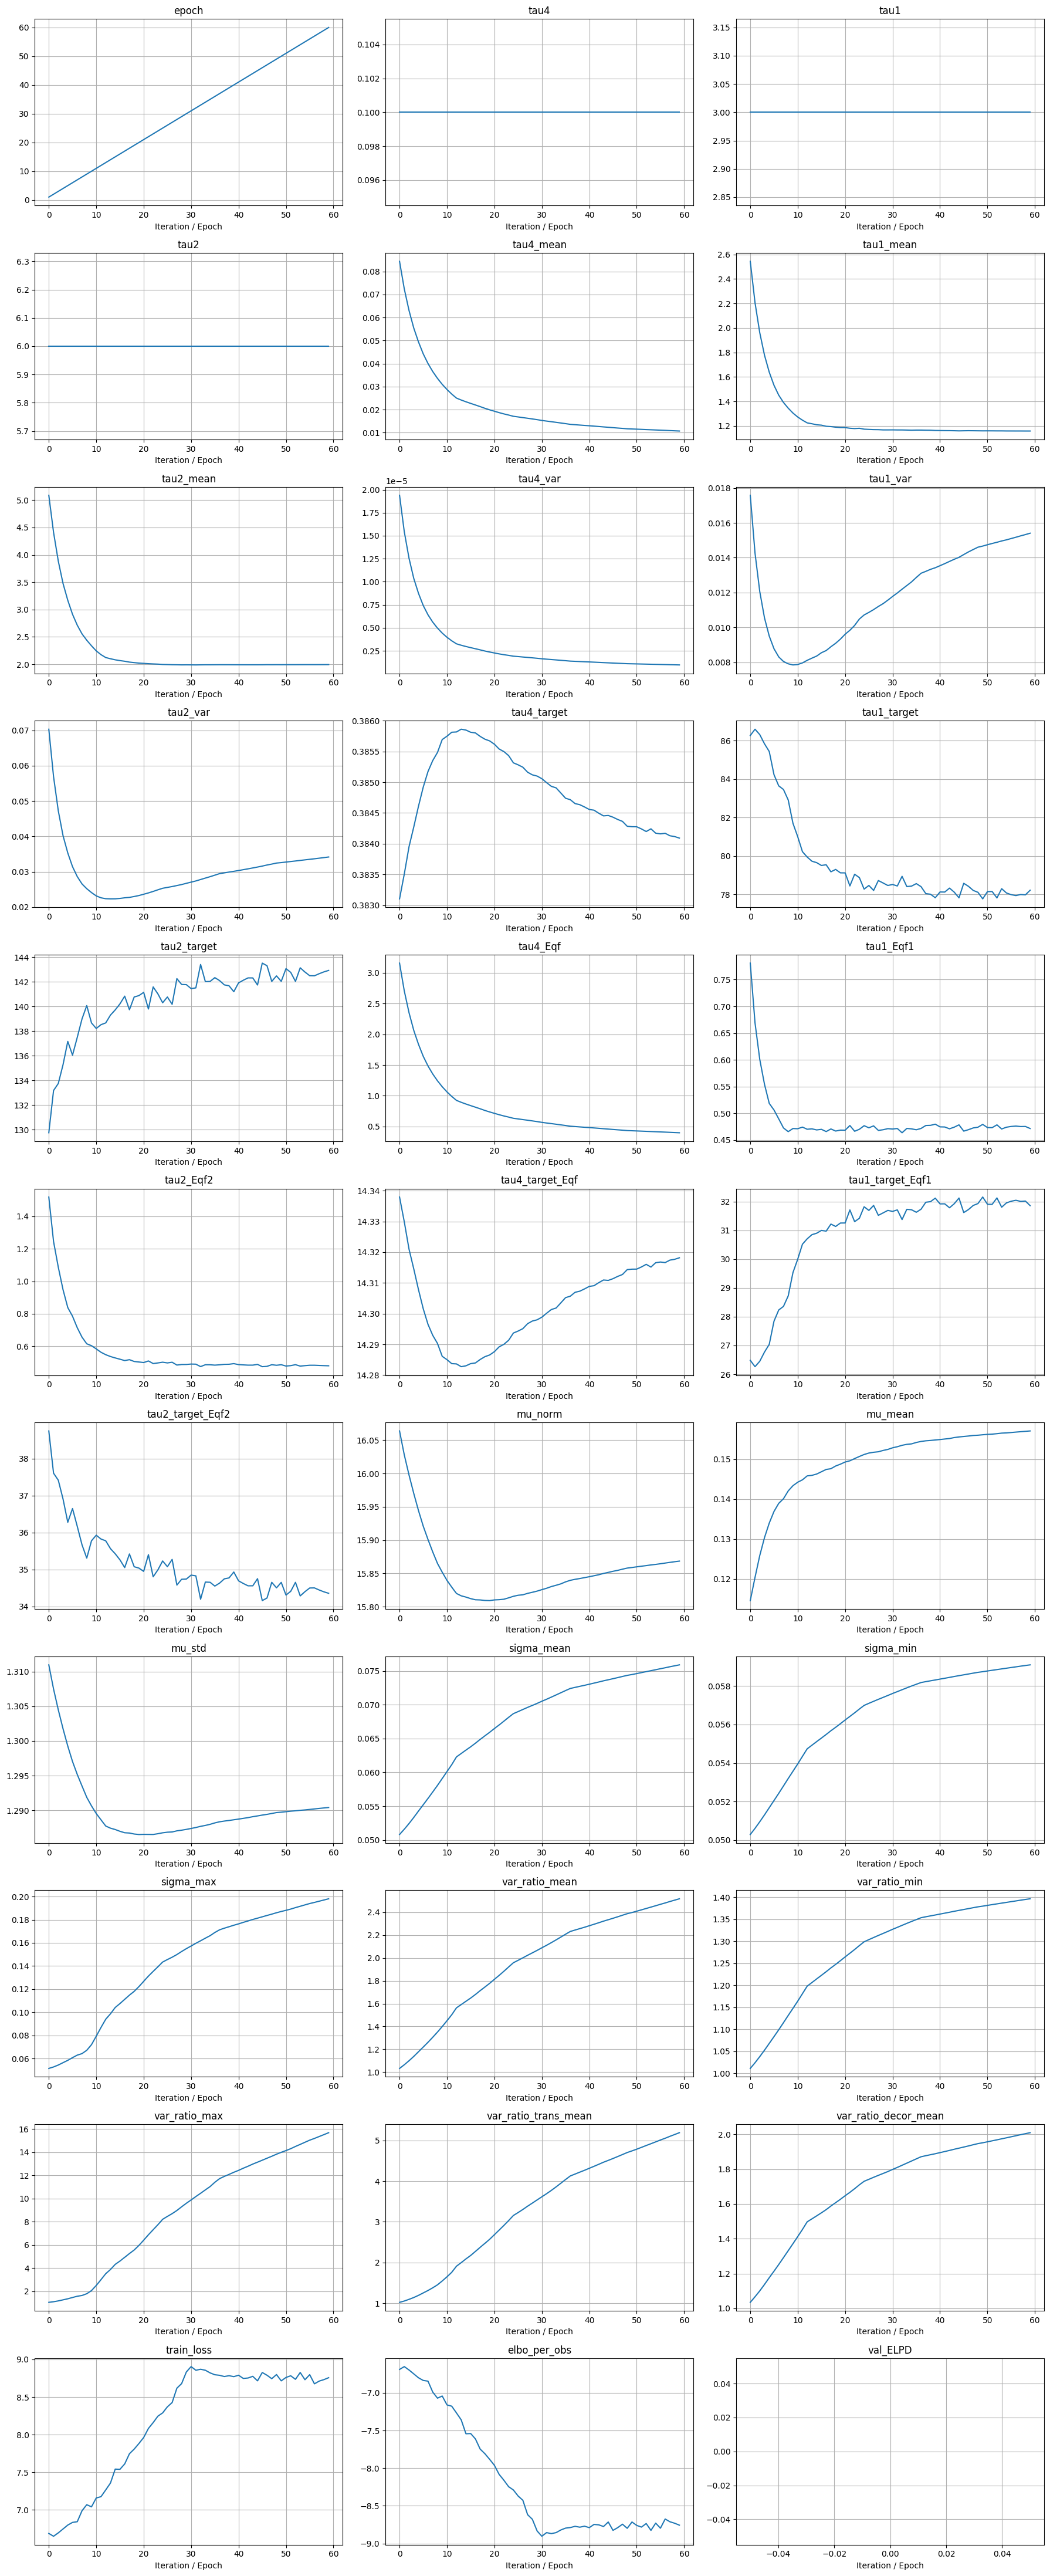

In [33]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [34]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



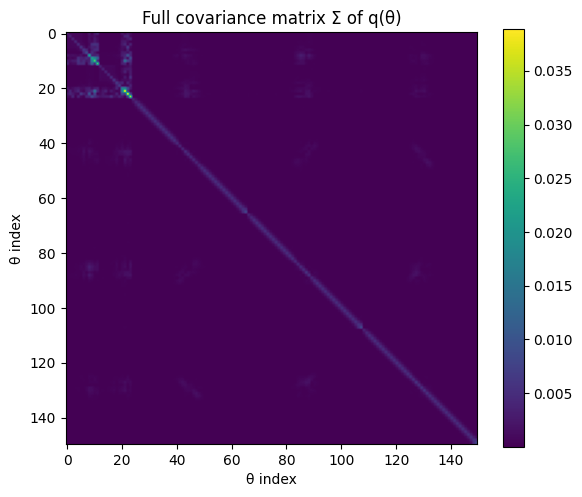

In [35]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


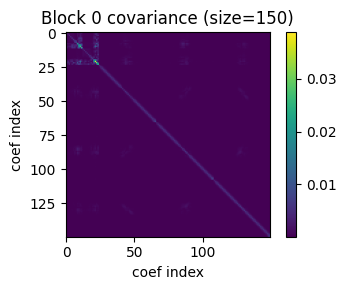

In [36]:
def plot_blocks_covariance(VI):
    import matplotlib.pyplot as plt

    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [37]:
import torch
import math
from torch.nn.utils.stateless import _reparametrize_module

def sample_bayesian_predictive(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    n_samples: int,
    S: int = 32,
    decor_present: bool = True,
):
    """
    Draw samples from the Bayesian predictive:
        p(y) ≈ (1/S) ∑_s p(y | θ_s, τ_s)
    by:
      - sampling θ_s ~ q(θ)
      - sampling τ_s ~ q(τ) (if tau_nodes is not None)
      - for each s, drawing n_samples/S from model with those parameters
    """
    device = model.device
    S = min(S, n_samples)
    n_per = math.ceil(n_samples / S)

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    # sample taus for each s (or fall back to hyperparameters)
    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    samples_all = []

    for s in range(S):
        theta_s = theta_samples[s]

        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            # if your sample() does not take taus, you can instead
            # stash them into model.hyperparameter[...] before calling sample
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            y_s = model.sample(n_per)  # shape [n_per, d]
            samples_all.append(y_s)

    y_cat = torch.cat(samples_all, dim=0)
    return y_cat[:n_samples]


def log_prob_bayesian_mixture(
    model,
    VI,
    tau_nodes,
    hyper_T,
    hyper_D,
    y: torch.Tensor, # [N, d]
    S: int = 32,
    decor_present: bool = True,
):
    """
    Compute log p(y) under the Bayesian predictive via log-mean-exp over θ, τ.
    """
    device = model.device
    N = y.shape[0]

    theta_samples = VI.sample_theta(S, antithetic=True)  # [S, D]

    if tau_nodes is not None:
        tau4_vec, tau1_vec, tau2_vec, _ = tau_nodes.sample_many(
            S=S,
            decor_present=decor_present,
            generator=VI._rng,
        )
    else:
        tau4_vec = torch.full((S,), float(hyper_T["tau"]),  device=device)
        if decor_present:
            tau1_vec = torch.full((S,), float(hyper_D["tau_1"]), device=device)
            tau2_vec = torch.full((S,), float(hyper_D["tau_2"]), device=device)
        else:
            tau1_vec = torch.zeros((S,), device=device)
            tau2_vec = torch.zeros((S,), device=device)

    logps = []

    for s in range(S):
        theta_s = theta_samples[s]
        params_s = VI._theta_to_state_dict(theta_s)

        with _reparametrize_module(model, params_s):
            model.hyperparameter["transformation"]["tau"] = float(tau4_vec[s].item())
            if decor_present:
                model.hyperparameter["decorrelation"]["tau_1"] = float(tau1_vec[s].item())
                model.hyperparameter["decorrelation"]["tau_2"] = float(tau2_vec[s].item())

            # adapt this to your GTM's density API
            # e.g. if you have model.log_prob(y):
            ll_s = model.log_likelihood(y)     # [N]
            logps.append(ll_s)

    logps = torch.stack(logps, dim=0)   # [S, N]

    # log mean exp over S
    m, _ = torch.max(logps, dim=0, keepdim=True)
    log_mean = m.squeeze(0) + torch.log(torch.mean(torch.exp(logps - m), dim=0))  # [N]

    return log_mean  # [N]


In [38]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

log_likelihood_train_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_train,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_validate_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_validate,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

log_likelihood_test_bgtm = log_prob_bayesian_mixture(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    y=simulated_data_test,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

#log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
#log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
#log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [39]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [40]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0438
KLD GTM      Train Data:  0.0431
KLD Gaussian Train Data:  0.1146
KLD Copula   Train Data:  -0.0021

KLD BGTM      Test  Data:  0.0431
KLD GTM      Test  Data:  0.0435
KLD Gaussian Test  Data:  0.1126
KLD Copula   Test  Data:  0.0023


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [41]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = sample_bayesian_predictive(
    model=model,
    VI=VI,
    tau_nodes=tau_nodes,
    hyper_T=hyper_T,
    hyper_D=hyper_D,
    n_samples=10_000,
    S=32,
    decor_present=(model.number_decorrelation_layers > 0 and not model.transform_only),
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


In [42]:
D = VI.mu.numel()
print("D =", D)
print("num_diag =", VI.num_diag)
print("block_sizes =", VI.block_sizes)
print("L_unconstrained length =", VI.L_unconstrained.numel())

expected_tris = sum(k * (k + 1) // 2 for k in VI.block_sizes)
print("expected_tris =", expected_tris)


D = 150
num_diag = 0
block_sizes = [150]
L_unconstrained length = 11325
expected_tris = 11325


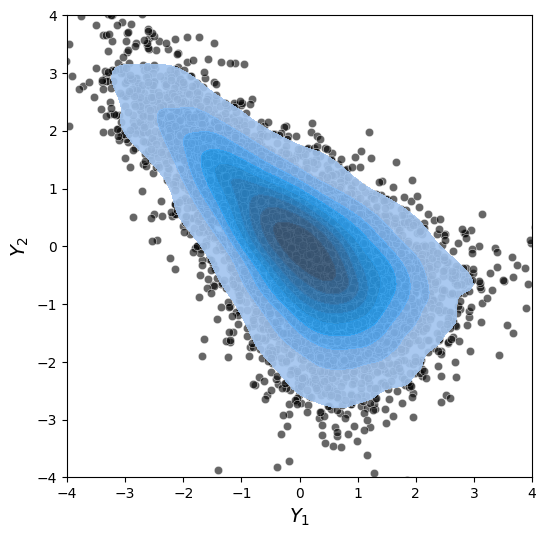

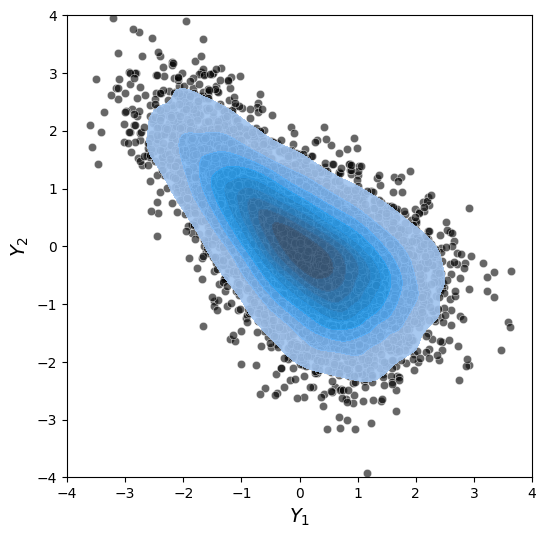

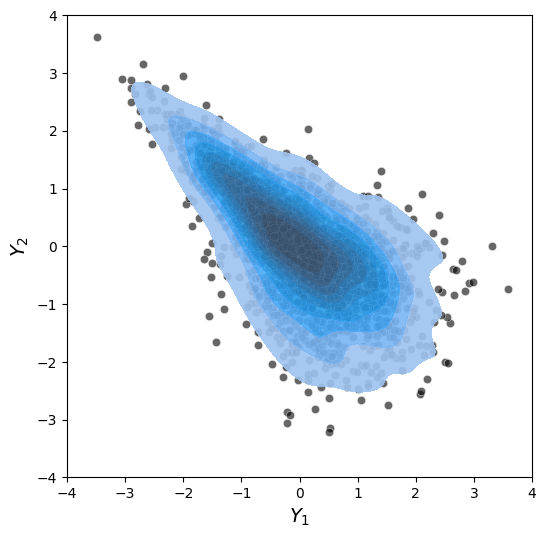

In [43]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [23]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [24]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


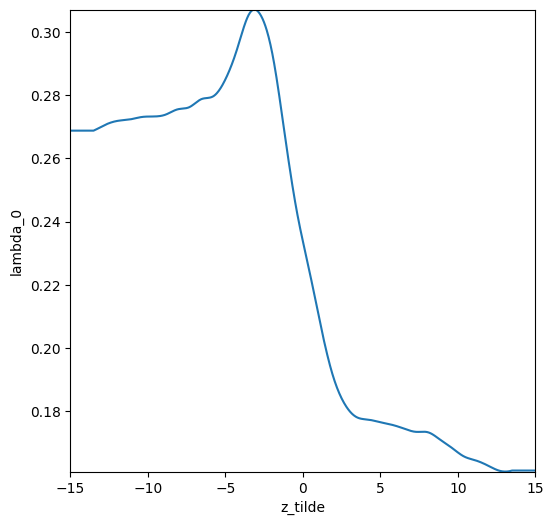

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


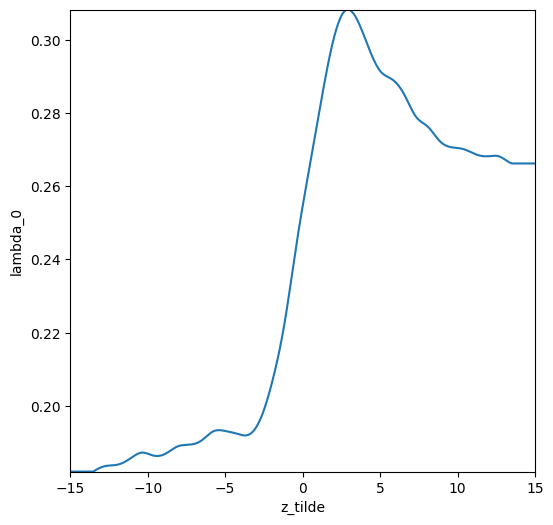

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


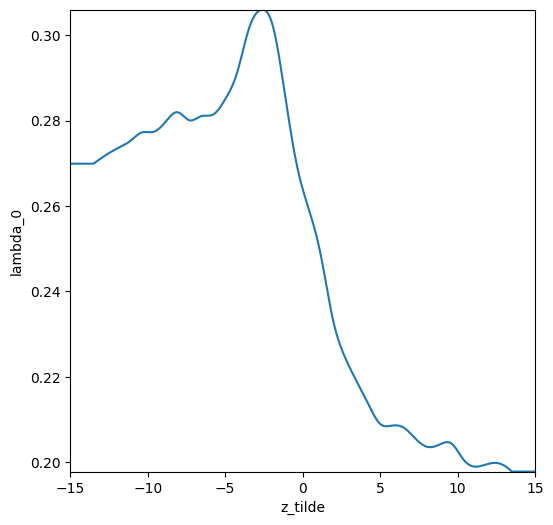

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)